In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as scp
import glob
import h5py
import os

# Tabula Muris sample identification

Only interested in the Tabula Muris samples that have Kidney or Liver tissue

In [3]:
meta_df = pd.read_csv('/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/meta_data/Tabula_muris_senis/Tabula_muris_droplet_new.csv')
meta_df

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,index,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,n_counts,louvain,cluster_names,cell1
0,AAACCTGAGTCCTCCT-1-47-1-0,1m,10X_P5_4_AAACCTGAGTCCTCCT,bladder cell,CL:1001319,bladder mesenchymal cell (Car3+),droplet,1-M-63,3301,male,BLADDER,Bladder,11976.0000,2.0,2_bladder cell,10X_P5_4_S5_L00_AAACCTGAGTCCTCCT
1,AAACCTGCAGCTATTG-1-47-1-0,1m,10X_P5_4_AAACCTGCAGCTATTG,bladder urothelial cell,CL:1001428,luminal bladder epithelial cell (umbrella cell),droplet,1-M-63,2236,male,BLADDER,Bladder,7275.0000,6.0,6_bladder urothelial cell,10X_P5_4_S5_L00_AAACCTGCAGCTATTG
2,AAAGATGAGCAGGCTA-1-47-1-0,1m,10X_P5_4_AAAGATGAGCAGGCTA,bladder cell,CL:1001319,bladder mesenchymal cell (Car3+),droplet,1-M-63,3670,male,BLADDER,Bladder,14773.0000,2.0,2_bladder cell,10X_P5_4_S5_L00_AAAGATGAGCAGGCTA
3,AAAGCAAGTCTCTTAT-1-47-1-0,1m,10X_P5_4_AAAGCAAGTCTCTTAT,bladder cell,CL:1001319,bladder mesenchymal cell (Scara5+),droplet,1-M-63,2699,male,BLADDER,Bladder,7755.0000,3.0,3_bladder cell,10X_P5_4_S5_L00_AAAGCAAGTCTCTTAT
4,AAAGCAATCCACGAAT-1-47-1-0,1m,10X_P5_4_AAAGCAATCCACGAAT,bladder cell,CL:1001319,bladder mesenchymal cell (Scara5+),droplet,1-M-63,2742,male,BLADDER,Bladder,9122.0000,3.0,3_bladder cell,10X_P5_4_S5_L00_AAAGCAATCCACGAAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107507,10X_P8_15_TTTGTCACAGTCTTCC-1,3m,10X_P8_15_TTTGTCACAGTCTTCC,fibroblast,CL:0000057,NaN,droplet,3-M-7/8,2557,male,NaN,Trachea,6347.3150,3.0,2_fibroblast,10X_P8_15_S16_L00_TTTGTCACAGTCTTCC
107508,10X_P8_15_TTTGTCAGTACATGTC-1,3m,10X_P8_15_TTTGTCAGTACATGTC,basal epithelial cell of tracheobronchial tree,CL:0002329,NaN,droplet,3-M-7/8,1585,male,NaN,Trachea,5039.7280,5.0,6_basal epithelial cell of tracheobronchial tree,10X_P8_15_S16_L00_TTTGTCAGTACATGTC
107509,10X_P8_15_TTTGTCAGTGCGCTTG-1,3m,10X_P8_15_TTTGTCAGTGCGCTTG,mesenchymal progenitor cell,CL:0000134,NaN,droplet,3-M-7/8,2166,male,NaN,Trachea,6518.3643,4.0,1_mesenchymal progenitor cell,10X_P8_15_S16_L00_TTTGTCAGTGCGCTTG
107510,10X_P8_15_TTTGTCAGTTGTCGCG-1,3m,10X_P8_15_TTTGTCAGTTGTCGCG,endothelial cell,CL:000115,NaN,droplet,3-M-7/8,2256,male,NaN,Trachea,6355.1133,7.0,9_endothelial cell,10X_P8_15_S16_L00_TTTGTCAGTTGTCGCG


In [4]:
meta_df.head().T

,0,1,2,3,4
index,AAACCTGAGTCCTCCT-1-47-1-0,AAACCTGCAGCTATTG-1-47-1-0,AAAGATGAGCAGGCTA-1-47-1-0,AAAGCAAGTCTCTTAT-1-47-1-0,AAAGCAATCCACGAAT-1-47-1-0
age,1m,1m,1m,1m,1m
cell,10X_P5_4_AAACCTGAGTCCTCCT,10X_P5_4_AAACCTGCAGCTATTG,10X_P5_4_AAAGATGAGCAGGCTA,10X_P5_4_AAAGCAAGTCTCTTAT,10X_P5_4_AAAGCAATCCACGAAT
cell_ontology_class,bladder cell,bladder urothelial cell,bladder cell,bladder cell,bladder cell
cell_ontology_id,CL:1001319,CL:1001428,CL:1001319,CL:1001319,CL:1001319
free_annotation,bladder mesenchymal cell (Car3+),luminal bladder epithelial cell (umbrella cell),bladder mesenchymal cell (Car3+),bladder mesenchymal cell (Scara5+),bladder mesenchymal cell (Scara5+)
method,droplet,droplet,droplet,droplet,droplet
mouse.id,1-M-63,1-M-63,1-M-63,1-M-63,1-M-63
n_genes,3301,2236,3670,2699,2742
sex,male,male,male,male,male


In [8]:
meta_df[meta_df['tissue'].eq('Kidney')].shape

(9488, 16)

In [7]:
meta_df[meta_df['tissue'].eq('Liver')].shape

(5490, 16)

In [10]:
meta_df[meta_df['tissue'].eq('Kidney')].head()

,index,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,n_counts,louvain,cluster_names,cell1
9171,AAACCTGAGACTGGGT-1-1-1-0,30m,10X_P1_1_AAACCTGAGACTGGGT,epithelial cell of proximal tubule,CL:0002306,Epcam proximal tube epithelial cell,droplet,30-M-2,2349,male,KIDNEY,Kidney,9945.0,6.0,6_epithelial cell of proximal tubule,10X_P1_1_S1_L00_AAACCTGAGACTGGGT
9172,AAACCTGAGATGTAAC-1-1-1-0,30m,10X_P1_1_AAACCTGAGATGTAAC,fibroblast,CL:0000057,Stroma fibroblast,droplet,30-M-2,1856,male,KIDNEY,Kidney,4779.0,22.0,22_fibroblast,10X_P1_1_S1_L00_AAACCTGAGATGTAAC
9173,AAACCTGAGGCTAGAC-1-1-1-0,30m,10X_P1_1_AAACCTGAGGCTAGAC,fibroblast,CL:0000057,Stroma fibroblast,droplet,30-M-2,1497,male,KIDNEY,Kidney,4464.0,22.0,22_fibroblast,10X_P1_1_S1_L00_AAACCTGAGGCTAGAC
9174,AAACCTGGTAGAGCTG-1-1-1-0,30m,10X_P1_1_AAACCTGGTAGAGCTG,kidney distal convoluted tubule epithelial cell,CL:1000849,Epcam kidney distal convoluted tubule epit...,droplet,30-M-2,3055,male,KIDNEY,Kidney,9598.0,11.0,11_kidney distal convoluted tubule epithelial ...,10X_P1_1_S1_L00_AAACCTGGTAGAGCTG
9175,AAACCTGGTCATTAGC-1-1-1-0,30m,10X_P1_1_AAACCTGGTCATTAGC,podocyte,CL:0000653,Epcam podocyte,droplet,30-M-2,1226,male,KIDNEY,Kidney,3191.0,13.0,13_podocyte,10X_P1_1_S1_L00_AAACCTGGTCATTAGC


In [20]:
cell_split_id = meta_df[meta_df['tissue'].eq('Kidney')]['cell'].str.split('_')

kidney_cells = pd.DataFrame({
    'mouse':cell_split_id.str[1],
    'sample':cell_split_id.str[2],
    'cell_bc':cell_split_id.str[3],
})

kidney_cells.groupby(['mouse','sample']).size().reset_index(name='number_of_cells')

,mouse,sample,number_of_cells
0,P1,1,1734
1,P1,9,1277
2,P2,0,1225
3,P3,7,935
4,P4,5,485
5,P4,6,595
6,P5,8,1163
7,P5,9,1054
8,P7,5,1020


In [86]:
kidney_cells.drop_duplicates(['mouse','sample'])[['mouse','sample']]

,mouse,sample
9171,P1,1
10905,P1,9
12182,P2,0
13407,P3,7
14342,P5,8
15505,P5,9
16559,P4,5
17044,P4,6
17639,P7,5


In [21]:
cell_split_id = meta_df[meta_df['tissue'].eq('Liver')]['cell'].str.split('_')

liver_cells = pd.DataFrame({
    'mouse':cell_split_id.str[1],
    'sample':cell_split_id.str[2],
    'cell_bc':cell_split_id.str[3],
})

liver_cells.groupby(['mouse','sample']).size().reset_index(name='number_of_cells')

,mouse,sample,number_of_cells
0,P1,16,1885
1,P2,10,115
2,P2,11,211
3,P2,3,45
4,P4,2,375
5,P5,0,447
6,P5,1,776
7,P5,7,1157
8,P7,0,322
9,P7,1,157


In [88]:
liver_cells.drop_duplicates(['mouse','sample'])[['mouse','sample']]

,mouse,sample
31302,P1,16
33187,P2,3
33232,P2,10
33347,P2,11
33558,P5,0
34005,P5,1
34781,P5,7
35938,P4,2
36313,P7,0
36635,P7,1


# Creating a BED of the Liver/Kidney genes of interest

In [65]:
gene_list_paths = [
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/KidneyLiver_preprocessing/all_genes.txt',
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/vz_Liver_showcase_preprocessing/all_genes.txt',
]

genes = sorted(list(set(g.strip() for p in gene_list_paths for g in open(p))))
print(len(genes))
genes

601


['1700011h14Rik',
 '1700061G19Rik',
 '2210010c04Rik',
 '4631405k08Rik',
 'Abcb4',
 'Abcc8',
 'Acaca',
 'Acacb',
 'Ace',
 'Ace2',
 'Acsbg1',
 'Acsbg2',
 'Acsf3',
 'Acsl1',
 'Acsl4',
 'Acsl5',
 'Acsl6',
 'Acss1',
 'Acss2',
 'Acta2',
 'Actn4',
 'Adamts9',
 'Adgre1',
 'Adh4',
 'Adh7',
 'Adpgk',
 'Aebp1',
 'Ak4',
 'Akap14',
 'Akr1a1',
 'Akr1c18',
 'Akr1d1',
 'Alas1',
 'Alas2',
 'Alcam',
 'Aldh1b1',
 'Aldh3a1',
 'Aldh3a2',
 'Aldh3b1',
 'Aldh3b2',
 'Aldh3b3',
 'Aldh7a1',
 'Aldoart1',
 'Aldoart2',
 'Aldoc',
 'Alox5ap',
 'Ammecr1',
 'Angpt1',
 'Angpt2',
 'Aplp1',
 'Apobec3',
 'Apold1',
 'Aqp1',
 'Aqp2',
 'Arg2',
 'Arhgdib',
 'Arsb',
 'Atp1b1',
 'Atp1b3',
 'Atp2a2',
 'Axin2',
 'B4galt6',
 'Bambi',
 'Bank1',
 'Bbox1',
 'Bcam',
 'Bcl11a',
 'Bcl11b',
 'Bgn',
 'Blk',
 'Bmp2',
 'Bmp5',
 'Bmp7',
 'Bpgm',
 'Btnl9',
 'C1qa',
 'C1qb',
 'C1qc',
 'Calcrl',
 'Cald1',
 'Calm1',
 'Cav1',
 'Cav2',
 'Cbr4',
 'Ccdc80',
 'Ccl6',
 'Ccr1',
 'Ccr2',
 'Cd177',
 'Cd19',
 'Cd22',
 'Cd247',
 'Cd300lg',
 'Cd34',
 'Cd37',

In [66]:
#Going to create a BED of just the genes of interest
full_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/rob/readzs_fork/gencode.vM10.annotation.gff3',
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','stop','dot1','strand','dot2','info'],
)

full_gtf['gene_name'] = full_gtf['info'].str.extract('gene_name=(.*?);')
full_gtf['gene_id'] = full_gtf['info'].str.extract('gene_id=(.*?);')

gene_df = full_gtf.loc[full_gtf['kind'].eq('gene'),['gene_name','gene_id','chrom','source','start','stop','strand']]
gene_df

,gene_name,gene_id,chrom,source,start,stop,strand
0,4933401J01Rik,ENSMUSG00000102693.1,chr1,HAVANA,3073253,3074322,+
3,Gm26206,ENSMUSG00000064842.1,chr1,ENSEMBL,3102016,3102125,+
6,Xkr4,ENSMUSG00000051951.5,chr1,HAVANA,3205901,3671498,-
24,Gm18956,ENSMUSG00000102851.1,chr1,HAVANA,3252757,3253236,+
27,Gm37180,ENSMUSG00000103377.1,chr1,HAVANA,3365731,3368549,-
...,...,...,...,...,...,...,...
1613316,mt-Nd6,ENSMUSG00000064368.1,chrM,ENSEMBL,13552,14070,-
1613322,mt-Te,ENSMUSG00000064369.1,chrM,ENSEMBL,14071,14139,-
1613325,mt-Cytb,ENSMUSG00000064370.1,chrM,ENSEMBL,14145,15288,+
1613330,mt-Tt,ENSMUSG00000064371.1,chrM,ENSEMBL,15289,15355,+


In [67]:
#These genes aren't in the gff3 file (maybe they have a different name?)
set(genes).difference(gene_df['gene_name'])

{'1700011h14Rik',
 '2210010c04Rik',
 '4631405k08Rik',
 'ComtLdha',
 'Cybasc3',
 'Cyp2c23',
 'Darc',
 'Eltd1',
 'Faim3',
 'Gpr116',
 'Igj',
 'Tent5c'}

In [68]:
#Ok I was able to match more genes but couldn't find synonyms for the first 4 which I guess is fine
gene_synonyms = {
    #'':'1700011h14Rik',
    #'':'2210010c04Rik',
    #'':'4631405k08Rik',
    #'':'ComtLdha',
    'Cyb561a3':'Cybasc3',
    'Cyp2c44':'Cyp2c23',
    'Ackr1':'Darc',
    'Adgrl4':'Eltd1',
    'Fcmr':'Faim3',
    'Adgrf5':'Gpr116',
    'Jchain':'Igj',
    'Fam46c':'Tent5c',
}
gene_df['gene_name'] = gene_df['gene_name'].replace(gene_synonyms)
set(genes).difference(gene_df['gene_name'])

{'1700011h14Rik', '2210010c04Rik', '4631405k08Rik', 'ComtLdha'}

In [82]:
sub_gene_df = gene_df[gene_df['gene_name'].isin(genes)].drop_duplicates('gene_name')

#chr start end gene strand #<-- header line I need in the bed
col_renames = {
    'chrom':'#chr',
    'start':'start',
    'stop':'end',
    'gene_name':'gene',
    'strand':'strand',
}
sub_gene_df = sub_gene_df.rename(columns=col_renames)[col_renames.values()]
sub_gene_df['start'] -= 100 #be lenient
sub_gene_df['end'] += 100 #be lenient
sub_gene_df

,#chr,start,end,gene,strand
172,chr1,4490831,4497454,Sox17,-
14136,chr1,36761698,36782918,Zap70,+
20626,chr1,45907968,45926623,Slc40a1,-
21317,chr1,51289026,51303060,Sdpr,+
23683,chr1,53755406,53785324,Stk17b,-
...,...,...,...,...,...
1589321,chrX,150547275,150570738,Alas2,+
1594566,chrX,160122109,160138513,Pdha1,-
1597170,chrX,164088730,164118960,Tmem27,+
1597221,chrX,164139232,164188520,Ace2,+


In [84]:
sub_gene_df.to_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/kidney_liver_genes.bed',
    sep = ' ',
    index=False,
)

# Creating the metadata file for ReadZs

In [89]:
example_df = pd.read_csv(
    '/oak/stanford/groups/horence/rob/readzs_fork/MOp_10Xv3_metadata_with_mouse.tsv',
    sep = '\t',
    nrows = 10,
)
example_df

,cell_id,cluster_id,library,cell_bc,cluster_label,subclass_label,class_label,cluster_color,size,mouse
0,L8TX_181211_01_G12_AAACCCAAGCTTCATG,42,L8TX_181211_01_G12,AAACCCAAGCTTCATG,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
1,L8TX_181211_01_G12_AAACCCACACCAGCCA,42,L8TX_181211_01_G12,AAACCCACACCAGCCA,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
2,L8TX_181211_01_G12_AAACGAACAACGATTC,42,L8TX_181211_01_G12,AAACGAACAACGATTC,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
3,L8TX_181211_01_G12_AAACGAATCTCGTGAA,42,L8TX_181211_01_G12,AAACGAATCTCGTGAA,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
4,L8TX_181211_01_G12_AAACGCTGTAGTCACT,42,L8TX_181211_01_G12,AAACGCTGTAGTCACT,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
5,L8TX_181211_01_G12_AAAGAACGTACTAAGA,42,L8TX_181211_01_G12,AAAGAACGTACTAAGA,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
6,L8TX_181211_01_G12_AAAGGATCAAGTTCCA,42,L8TX_181211_01_G12,AAAGGATCAAGTTCCA,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
7,L8TX_181211_01_G12_AAAGGATCATCGCTAA,42,L8TX_181211_01_G12,AAAGGATCATCGCTAA,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
8,L8TX_181211_01_G12_AAAGGATGTCAGGTAG,42,L8TX_181211_01_G12,AAAGGATGTCAGGTAG,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
9,L8TX_181211_01_G12_AAAGGGCCAAGCGAAC,42,L8TX_181211_01_G12,AAAGGGCCAAGCGAAC,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003


In [98]:
meta_df = pd.read_csv(
    '/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/meta_data/Tabula_muris_senis/Tabula_muris_droplet_new.csv',
)
meta_df.head()

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,index,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,n_genes,sex,subtissue,tissue,n_counts,louvain,cluster_names,cell1
0,AAACCTGAGTCCTCCT-1-47-1-0,1m,10X_P5_4_AAACCTGAGTCCTCCT,bladder cell,CL:1001319,bladder mesenchymal cell (Car3+),droplet,1-M-63,3301,male,BLADDER,Bladder,11976.0,2.0,2_bladder cell,10X_P5_4_S5_L00_AAACCTGAGTCCTCCT
1,AAACCTGCAGCTATTG-1-47-1-0,1m,10X_P5_4_AAACCTGCAGCTATTG,bladder urothelial cell,CL:1001428,luminal bladder epithelial cell (umbrella cell),droplet,1-M-63,2236,male,BLADDER,Bladder,7275.0,6.0,6_bladder urothelial cell,10X_P5_4_S5_L00_AAACCTGCAGCTATTG
2,AAAGATGAGCAGGCTA-1-47-1-0,1m,10X_P5_4_AAAGATGAGCAGGCTA,bladder cell,CL:1001319,bladder mesenchymal cell (Car3+),droplet,1-M-63,3670,male,BLADDER,Bladder,14773.0,2.0,2_bladder cell,10X_P5_4_S5_L00_AAAGATGAGCAGGCTA
3,AAAGCAAGTCTCTTAT-1-47-1-0,1m,10X_P5_4_AAAGCAAGTCTCTTAT,bladder cell,CL:1001319,bladder mesenchymal cell (Scara5+),droplet,1-M-63,2699,male,BLADDER,Bladder,7755.0,3.0,3_bladder cell,10X_P5_4_S5_L00_AAAGCAAGTCTCTTAT
4,AAAGCAATCCACGAAT-1-47-1-0,1m,10X_P5_4_AAAGCAATCCACGAAT,bladder cell,CL:1001319,bladder mesenchymal cell (Scara5+),droplet,1-M-63,2742,male,BLADDER,Bladder,9122.0,3.0,3_bladder cell,10X_P5_4_S5_L00_AAAGCAATCCACGAAT


In [103]:
col_renames = {
    'cell':'cell_id',
    'free_annotation':'free_annotation',
    'cell_ontology_class':'cell_ontology_class',
    'tissue':'tissue',
    'mouse.id':'mouse_id',
    'sex':'sex',
    'age':'age',
}
meta_df = meta_df[
    meta_df['tissue'].isin(['Kidney','Liver'])
]
meta_df = meta_df.rename(columns=col_renames)[col_renames.values()]
meta_df.head()

,cell_id,free_annotation,cell_ontology_class,tissue,mouse_id,sex,age
9171,10X_P1_1_AAACCTGAGACTGGGT,Epcam proximal tube epithelial cell,epithelial cell of proximal tubule,Kidney,30-M-2,male,30m
9172,10X_P1_1_AAACCTGAGATGTAAC,Stroma fibroblast,fibroblast,Kidney,30-M-2,male,30m
9173,10X_P1_1_AAACCTGAGGCTAGAC,Stroma fibroblast,fibroblast,Kidney,30-M-2,male,30m
9174,10X_P1_1_AAACCTGGTAGAGCTG,Epcam kidney distal convoluted tubule epit...,kidney distal convoluted tubule epithelial cell,Kidney,30-M-2,male,30m
9175,10X_P1_1_AAACCTGGTCATTAGC,Epcam podocyte,podocyte,Kidney,30-M-2,male,30m


In [104]:
split_str = meta_df['cell_id'].str.split('_')
meta_df['cell_bc'] = split_str.str[3]
meta_df['library'] = split_str.str[1]+'_'+split_str.str[2]
meta_df.head()

,cell_id,free_annotation,cell_ontology_class,tissue,mouse_id,sex,age,cell_bc,library
9171,10X_P1_1_AAACCTGAGACTGGGT,Epcam proximal tube epithelial cell,epithelial cell of proximal tubule,Kidney,30-M-2,male,30m,AAACCTGAGACTGGGT,P1_1
9172,10X_P1_1_AAACCTGAGATGTAAC,Stroma fibroblast,fibroblast,Kidney,30-M-2,male,30m,AAACCTGAGATGTAAC,P1_1
9173,10X_P1_1_AAACCTGAGGCTAGAC,Stroma fibroblast,fibroblast,Kidney,30-M-2,male,30m,AAACCTGAGGCTAGAC,P1_1
9174,10X_P1_1_AAACCTGGTAGAGCTG,Epcam kidney distal convoluted tubule epit...,kidney distal convoluted tubule epithelial cell,Kidney,30-M-2,male,30m,AAACCTGGTAGAGCTG,P1_1
9175,10X_P1_1_AAACCTGGTCATTAGC,Epcam podocyte,podocyte,Kidney,30-M-2,male,30m,AAACCTGGTCATTAGC,P1_1


In [105]:
meta_df.to_csv(
    '/oak/stanford/groups/horence/rob/readzs_fork/tabula_muris_kidney_liver_metadata.tsv',
    sep='\t',
    index=False,
)

# Structure of data looks the same as MERFISH MOp dataset

* There is a global coordinate system used (which is great)
* Cell boundaries are saved as deeply nested hdf5 files
* Different features (field of views?) are saved as different hdf5s
* RNA spot locations are separately saved as CSVs
* Cell-type annotation data is contained in the h5ad files (three alternate approaches were used to annotate cells)

I need to identify which RNA spot belongs to which cell and make my own hdf5 objects

In [23]:
stem = '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/KidneyLiver_preprocessing/data'

## The RNA-spot x,y coordinates are in the cell_boundary zips at the first level



In [122]:
spots_path = os.path.join(stem,'VZG116','MsKidney_CellBoundary_VZG116_111921','barcodes.csv')
spots_df = pd.read_csv(spots_path,nrows=10, index_col=0)
spots_df

,barcode_id,global_x,global_y,global_z,x,y,fov
15027,1,60.294850,4139.9907,0.0,558.28564,1293.2473,0
15378,1,39.915333,4147.5140,1.0,369.58640,1362.9089,0
15711,1,39.696377,4146.4930,2.0,367.55905,1353.4525,0
15714,1,38.378930,4147.7925,2.0,355.36044,1365.4845,0
17381,2,42.090202,4172.0874,0.0,389.72410,1590.4384,0
17389,2,44.631676,4177.0527,0.0,413.25626,1636.4127,0
17399,2,124.657970,4182.4110,0.0,1154.24040,1686.0298,0
17404,2,72.460770,4185.3057,0.0,670.93304,1712.8289,0
17413,2,189.540280,4187.7754,0.0,1755.00260,1735.6995,0
17589,2,123.952400,4170.2866,1.0,1147.70740,1573.7634,0


# The cell boundary zips have hdf5's and metadata

I first extracted the following hdf5 from the zip by `unzip -p MsKidney_CellBoundary_VZG116_111921.zip MsKidney_CellBoundary_VZG116_111921/features/feature_data_426.hdf5 > feature_data_426.hdf5`

Then after all the unzipping I've just chosen feature 0

In [26]:
boundary_path = 'VZG116/MsKidney_CellBoundary_VZG116_111921/features/feature_data_0.hdf5'
h5_path = os.path.join(stem,boundary_path)
f = h5py.File(h5_path,'r')
f

<HDF5 file "feature_data_0.hdf5" (mode r)>

In [27]:
#Top level just has a single group and no attrs
print(dict(f.attrs))
print(f.keys())

{}
<KeysViewHDF5 ['featuredata']>


In [28]:
#The featuredata group has a version tag attribute
#and then an individual group for each cell keyed by cell-id
print(dict(f['featuredata'].attrs))
print(f['featuredata'].keys())

{'version': '0.1.9'}
<KeysViewHDF5 ['100103156195484539835846679900152827019', '100299055550742403838736454416457106378', '100508361727354390246543055490415090933', '101476277448225652664802681520983252404', '103728463955077055232451996731088051447', '104222948928279623114028829933895195341', '104526801981315108965592901153246583246', '105309408644564871164037469359287068640', '106370707215343124060643694237623883399', '106405441000697822475815192626529379185', '106663001722679040094866384247355692679', '107126195243196220662672457467932423550', '107340917873496722391902389343930622568', '108158240686793044318395000820003537507', '108878020415038133139664278871321516822', '111163574283754754217026357403380102771', '111543161655411050871845493560418495536', '112270083282318023924975570120851178170', '112725371820061477285802187269861341457', '112857067947364058072808131010050699657', '114493660372516245977362155515229273451', '114629009470983925689809934313144542720', '11577965621022429

In [29]:
#A cell group has bounding box attributes, fov, cell_id, and volume
#Then it has groups for the different z-slices, and a z_coordinates group
print(dict(f['featuredata']['100103156195484539835846679900152827019'].attrs))
print(f['featuredata']['100103156195484539835846679900152827019'].keys())

{'bounding_box': array([ 189.88422668, 4022.99589622,  190.46207989, 4023.50662963]), 'fov': 0, 'id': b'100103156195484539835846679900152827019', 'volume': 0.08124806670594717}
<KeysViewHDF5 ['zIndex_0', 'zIndex_1', 'zIndex_2', 'zIndex_3', 'zIndex_4', 'zIndex_5', 'zIndex_6', 'z_coordinates']>


In [30]:
#The z_coordinates is a list of the depth in microns of each slice
print(f['featuredata']['100103156195484539835846679900152827019']['z_coordinates'][:])

[ 1.5  3.   4.5  6.   7.5  9.  10.5]


In [31]:
#Within each z-slice there is another group. I don't know why though..
#ok I've checked below, and every z-slice only has a single p_0 group (in this hdf5 subset at least)
print(dict(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0'].attrs))
print(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0'].keys())

{}
<KeysViewHDF5 ['p_0']>


In [32]:
z = f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']

In [108]:
#There is another group within p which has the actual cell boundary polygons
print(dict(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0'].attrs))
print(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0'].keys())

{'type': b'Polygon'}
<KeysViewHDF5 ['coordinates']>


In [109]:
#The coordinates dataset doesn't have attributes, and is 3D, but only uses two axes
print(dict(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'].attrs))
print(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'])

{}
<HDF5 dataset "coordinates": shape (1, 89, 2), type "<f8">


In [110]:
#Can extract the 2D polygon points using:
f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'][0,:,:].shape

(89, 2)

In [127]:
f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'][0,:,:]

array([[ 189.99222669, 4023.50662963],
       [ 189.99900806, 4023.50641652],
       [ 190.00576268, 4023.50577802],
       [ 190.01246387, 4023.50471665],
       [ 190.01908519, 4023.50323661],
       [ 190.02560052, 4023.50134373],
       [ 190.03198414, 4023.49904549],
       [ 190.03821085, 4023.49635095],
       [ 190.04425608, 4023.49327075],
       [ 190.05009598, 4023.48981705],
       [ 190.05570749, 4023.48600347],
       [ 190.06106848, 4023.48184506],
       [ 190.06615777, 4023.47735824],
       [ 190.0709553 , 4023.47256072],
       [ 190.07544212, 4023.46747142],
       [ 190.07960052, 4023.46211044],
       [ 190.0834141 , 4023.45649892],
       [ 190.08686781, 4023.45065903],
       [ 190.08994801, 4023.44461379],
       [ 190.09264255, 4023.35887217],
       [ 190.08994801, 4023.35264546],
       [ 190.08686781, 4023.34660023],
       [ 190.0834141 , 4023.34076033],
       [ 190.07960052, 4023.33514882],
       [ 190.07544212, 4023.32978783],
       [ 190.0709553 , 40

In [124]:
len(f['featuredata']['100103156195484539835846679900152827019']['zIndex_0'])

1

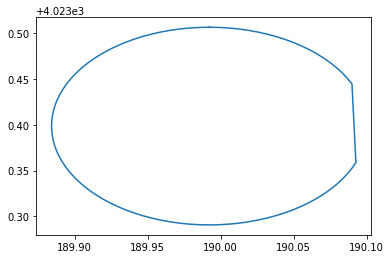

In [111]:
#
pts = f['featuredata']['100103156195484539835846679900152827019']['zIndex_0']['p_0']['coordinates'][0,:,:]
xs = pts[:,0]
ys = pts[:,1]
plt.plot(xs,ys)
plt.show()
plt.close()

In [112]:
#the bounding box makes sense with the cell shape above
#so I think I've gotten the x and y points in the correct order
f['featuredata']['100103156195484539835846679900152827019'].attrs['bounding_box']

array([ 189.88422668, 4022.99589622,  190.46207989, 4023.50662963])

## Below is showing that there are just 1 "p-groups" in each z-slice group

And sometimes 0 if that z-slice doesn't have any data

In [113]:
cell_ps = {
    'cell_id':[],
    'num_zs':[],
    'z':[],
    'num_ps_at_z':[],
}

for cell_id in f['featuredata']:
    cell = f['featuredata'][cell_id]
    for i,z in enumerate(cell['z_coordinates']):
        z_slice = cell['zIndex_{}'.format(i)]
        num_ps = sum(1 for p in z_slice)
        
        cell_ps['cell_id'].append(cell_id)
        cell_ps['num_zs'].append(len(cell['z_coordinates']))
        cell_ps['z'].append('zIndex_{}'.format(i))
        cell_ps['num_ps_at_z'].append(num_ps)
        
cell_ps_df = pd.DataFrame(cell_ps)
cell_ps_df

,cell_id,num_zs,z,num_ps_at_z
0,100103156195484539835846679900152827019,7,zIndex_0,1
1,100103156195484539835846679900152827019,7,zIndex_1,1
2,100103156195484539835846679900152827019,7,zIndex_2,0
3,100103156195484539835846679900152827019,7,zIndex_3,0
4,100103156195484539835846679900152827019,7,zIndex_4,0
...,...,...,...,...
3110,99742140856582517701933144235126120651,7,zIndex_2,1
3111,99742140856582517701933144235126120651,7,zIndex_3,0
3112,99742140856582517701933144235126120651,7,zIndex_4,0
3113,99742140856582517701933144235126120651,7,zIndex_5,0


In [97]:
#Even if a cell doesn't have info at all z-slices, the z_coordinates will always list all
cell_ps_df['num_zs'].value_counts()

7    3115
Name: num_zs, dtype: int64

3.0

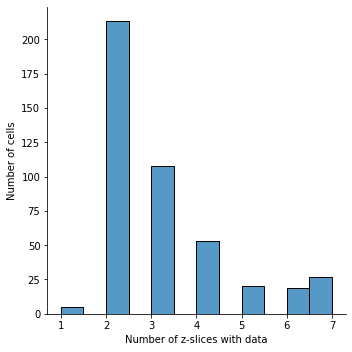

In [98]:
#The median number of non-empty z-slices per cell is 3
zs_with_data_per_cell = cell_ps_df.groupby('cell_id')['num_ps_at_z'].apply(lambda x: sum(x > 0))
display(zs_with_data_per_cell.median())
sns.displot(zs_with_data_per_cell)
plt.xlabel('Number of z-slices with data')
plt.ylabel('Number of cells')
plt.show()
plt.close()

In [99]:
#At most, each z-slice has a single p-group
cell_ps_df['num_ps_at_z'].max()

1

# The h5ad files have cell x gene counts

There are 3 types of h5ad files for each tissue (Liver and Kidney)

The VI stands for "Variational Inference"

1. [scANVI](https://www.embopress.org/doi/full/10.15252/msb.20209620) h5ads are MERFISH cells with cell-types called by an algorithm scANVI that predicts cell-type labels and is trained on the Tabula Muris Senis dataset

2. [scVI](https://www.nature.com/articles/s41592-018-0229-2) was an alternative approach to assign cell-types to the MERFISH cells

3. MERFISH which has cell-types determined just by the MERFISH data, without leveraging any outside data

In [24]:
liver_adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','MERFISH_liver_object.h5ad'))
liver_adata

AnnData object with n_obs × n_vars = 19695 × 307
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'n_counts', 'leiden', 'tentative_annot'
    uns: 'QC_filter', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tentative_annot_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
len(liver_adata.var_names)

307

In [25]:
list(liver_adata.var_names)

['ptprc',
 'pecam1',
 'kdr',
 'cdh5',
 'cd19',
 'ms4a1',
 'cd79a',
 'cd79b',
 'bank1',
 'blk',
 'tnfrsf13c',
 'tnfrsf13b',
 'pax5',
 'faim3',
 's100a2',
 'krt5',
 'krt19',
 'sfn',
 '4631405k08rik',
 's100a14',
 'muc4',
 'sele',
 'cnksr3',
 'adamts9',
 'darc',
 'glyat',
 'ak4',
 'bbox1',
 'aqp1',
 'pdzk1',
 'tmem27',
 'slc9a3r2',
 'cldn5',
 'btnl9',
 'sox18',
 'vwf',
 'flt1',
 'clec14a',
 'gpihbp1',
 'egfl7',
 'tie1',
 'ldb2',
 'plvap',
 'gas1',
 'ccdc80',
 'ism1',
 'igf1',
 'igfbp6',
 'mfap5',
 'scara5',
 'fbn1',
 'sfrp2',
 'eltd1',
 'f8',
 'ptprb',
 'shank3',
 'emcn',
 'sdpr',
 'wdr72',
 'aqp2',
 'kcne1',
 'scnn1a',
 'sox17',
 'palmd',
 'tinagl1',
 'npdc1',
 'crip2',
 'hyal2',
 'mmrn2',
 'gja4',
 'kcnj1',
 'nudt4',
 'mal',
 'notch3',
 'acta2',
 'myl9',
 'myh11',
 'lmod1',
 'des',
 'vim',
 'fmo1',
 'alox5ap',
 'c1qc',
 'c1qa',
 'c1qb',
 'mrc1',
 'trem1',
 'trem2',
 'klra2',
 'bcl11b',
 'cd37',
 'cd247',
 'klrb1f',
 'klrb1c',
 'gzmb',
 'derl3',
 'igj',
 'wt1',
 'actn4',
 'synpo',
 'dag1

In [26]:
#Kidney scANVI 34,387 cells by 306 genes (cell-types called by scANVI which is trained on Tabula Muris)
adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','scANVI_kidney_object.h5ad'))
adata

AnnData object with n_obs × n_vars = 34387 × 306
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'tech', 'celltype_scanvi', '_scvi_batch', '_scvi_labels', 'predicted_cell_type'
    var: 'n_cells-scRNA-seq'
    uns: 'C_scANVI_colors', '_scvi', 'neighbors', 'tech_colors', 'umap'
    obsm: 'X_scANVI', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [27]:
list(adata.var_names)

['sox17',
 'zap70',
 'slc40a1',
 'sdpr',
 'cxcr2',
 'des',
 'scg2',
 'marco',
 'faim3',
 'prelp',
 'lmod1',
 'ptprc',
 'glul',
 'pappa2',
 'fmo1',
 'sele',
 'atp1b1',
 'cd247',
 'fcgr2b',
 'darc',
 'hsd11b1',
 'cd34',
 'cnksr3',
 'tcf21',
 'oit3',
 'prf1',
 'neurog3',
 'derl3',
 'elane',
 'stab2',
 'igf1',
 'hal',
 'nudt4',
 'dcn',
 'lum',
 'tspan8',
 'ptprb',
 'gpr182',
 'rdh7',
 'aebp1',
 'ramp3',
 'bcl11a',
 'btnl9',
 'flt4',
 'gpx3',
 'sparc',
 'tnfrsf13b',
 'mfap4',
 'cd68',
 'cldn7',
 'serpinf1',
 'vtn',
 'ccl6',
 'hnf1b',
 'igfbp4',
 'krt19',
 'dnajc7',
 'ptrf',
 'cd300lg',
 'cd79b',
 'pecam1',
 'colec11',
 'tspan13',
 'clec14a',
 'dbpht2',
 'arg2',
 'calm1',
 'chga',
 'bcl11b',
 'pld4',
 'crip2',
 'ptprn2',
 'ero1lb',
 'dcdc2a',
 'foxc1',
 'ly86',
 'ogn',
 'gas1',
 'fam159b',
 'gzmk',
 'dnase1l3',
 'kcnk16',
 'stab1',
 'mmrn2',
 'lgals3',
 '1700011h14rik',
 'rnase6',
 'gzmb',
 'blk',
 'scara5',
 'clu',
 'gulo',
 'il7r',
 'prlr',
 'slc30a8',
 'ly6c2',
 'gpihbp1',
 'mafa',
 'il2r

In [12]:
set(liver_adata.var_names).difference(adata.var_names)

{'4631405k08rik'}

In [28]:
set(adata.var_names).difference(liver_adata.var_names)

set()

In [118]:
#Kidney scANVI 36,714 cells by 306 genes
adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','scVI_kidney_object.h5ad'))
adata

AnnData object with n_obs × n_vars = 36714 × 306
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'tech', 'celltype_scanvi', '_scvi_batch', '_scvi_labels', 'predicted_cell_type'
    var: 'n_cells-scRNA-seq'
    uns: 'C_scANVI_colors', '_scvi', 'neighbors', 'tech_colors', 'umap'
    obsm: 'X_scANVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [119]:
#Liver scANVI 19,698 cells by 306 genes
adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','scANVI_liver_object.h5ad'))
adata

AnnData object with n_obs × n_vars = 19698 × 306
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'integrated_manually_annotated', 'batch', 'n_counts', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'tech', 'celltype_scanvi', '_scvi_batch', '_scvi_labels', 'predicted_cell_type'
    var: 'n_cells-scRNA-seq'
    uns: 'C_scANVI_colors', '_scvi', 'neighbors', 'tech_colors', 'umap'
    obsm: 'X_scANVI', 'X_umap', 'spatial'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [120]:
#Liver scANVI 22,019 cells by 306 genes
adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','scVI_liver_object.h5ad'))
adata

AnnData object with n_obs × n_vars = 22019 × 306
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'integrated_manually_annotated', 'batch', 'n_counts', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'tech', 'celltype_scanvi', '_scvi_batch', '_scvi_labels', 'predicted_cell_type'
    var: 'n_cells-scRNA-seq'
    uns: 'C_scANVI_colors', '_scvi', 'neighbors', 'tech_colors', 'umap'
    obsm: 'X_scANVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# Testing if gene-vars were correctly assigned

In [39]:
f = h5py.File(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/KidneyLiver_preprocessing/finished_outputs/liver_gv_filt.hdf5',
    'r',
)
f.keys()

<KeysViewHDF5 ['cell_ids', 'cells', 'genes']>

In [40]:
print(f['cell_ids'])
f['cell_ids'][:1]

<HDF5 dataset "cell_ids": shape (16175,), type "|S39">


array([b'100005199661550619447465419803033850982'], dtype='|S39')

In [41]:
cell = f['cells']['100005199661550619447465419803033850982']
cell.keys()

<KeysViewHDF5 ['boundaries', 'gene_vars', 'spot_coords', 'spot_genes']>

In [50]:
import collections
collections.Counter([g for z in cell['spot_genes'] for g in cell['spot_genes'][z]])

Counter({b'100.0': 1,
         b'123.0': 2,
         b'126.0': 36,
         b'128.0': 1,
         b'142.0': 11,
         b'143.0': 75,
         b'144.0': 3,
         b'145.0': 5,
         b'146.0': 7,
         b'147.0': 9,
         b'148.0': 3,
         b'149.0': 5,
         b'150.0': 1,
         b'153.0': 13,
         b'154.0': 14,
         b'169.0': 1,
         b'178.0': 1,
         b'183.0': 1,
         b'200.0': 1,
         b'202.0': 1,
         b'22.0': 2,
         b'238.0': 2,
         b'247.0': 1,
         b'25.0': 3,
         b'252.0': 8,
         b'256.0': 1,
         b'258.0': 1,
         b'259.0': 1,
         b'262.0': 1,
         b'268.0': 2,
         b'271.0': 5,
         b'276.0': 4,
         b'279.0': 2,
         b'280.0': 3,
         b'283.0': 2,
         b'284.0': 23,
         b'285.0': 2,
         b'286.0': 2,
         b'29.0': 1,
         b'291.0': 11,
         b'294.0': 1,
         b'3.0': 1,
         b'303.0': 19,
         b'31.0': 3,
         b'43.0': 1,
         

In [46]:
cell['gene_vars'][:]

array([0.33546326, 0.16719575, 0.02288674, 0.33546326, 0.07494129,
       0.00997997, 0.19999183, 0.14193265, 0.10967755, 0.08915158,
       0.19999183, 0.14193265, 0.33546326, 0.06452041, 0.0562678 ,
       0.33546326, 0.33546326, 0.33546326, 0.33546326, 0.33546326,
       0.16719575, 0.16719575, 0.33546326, 0.19999183, 0.08745624,
       0.33546326, 0.33546326, 0.33546326, 0.33546326, 0.16719575,
       0.14193265, 0.13289918, 0.16719575, 0.19999183, 0.16719575,
       0.03742612, 0.16719575, 0.16719575, 0.33546326, 0.07494129,
       0.33546326, 0.33546326, 0.04516735, 0.19999183, 0.33546326,
       0.14193265, 0.33546326, 0.10610499, 0.33546326, 0.33546326,
       0.33546326, 0.16719575, 0.33546326, 0.16719575, 0.33546326])

In [51]:
f.close()

In [52]:
a = collections.Counter()
a

Counter()

In [ ]:
a

# SLRRP hdf5 format

In [128]:
f = h5py.File('../inputs/m1s1_subset.hdf5','r')

In [131]:
dict(f.attrs)

{}

In [132]:
f.keys()

<KeysViewHDF5 ['cell_ids', 'cells', 'genes']>

In [134]:
f['cells'].keys()

<KeysViewHDF5 ['100090299132393774825374529480599642352', '102762322167228082486052775619884277102', '103963394979214788325793179983943807873', '104773525917171323315032845506736864421', '104887114217211410540888577620028568901', '106736575396305345683133461207739252997', '106771113274834466403933341586053551462', '111300904473796808480218743996654298162', '114601597319929030309061287706907914361', '114794480420405132420944298037591232478', '116545673785912319834287485202909229480', '116958434959714719022853807486346359847', '117278462105927683058902716691567767060', '118363099495240822175959718080964460592', '120885533126383545294034624420296038166', '131839580702053878622895713282850418670', '135221636419407451803412415350214899881', '140363262818590467334221980287927834774', '142291509029169734847215347686657429197', '142822951347518090322234372274331862666', '145531913712168956084196484724954151860', '145731456902179856722061144755427589556', '14602548646116620210766874686980335970

In [136]:
dict(f['cells']['7973318325035700141523338287728614297'].attrs)

{'annotation': 'unannotated',
 'num_genes': 90,
 'num_spots': 690,
 'zslices': array(['0', '1', '2', '3', '4', '5', '6'], dtype=object)}

In [137]:
f['cells']['7973318325035700141523338287728614297'].keys()

<KeysViewHDF5 ['boundaries', 'gene_vars', 'spot_coords', 'spot_genes']>

In [139]:
f['cells']['7973318325035700141523338287728614297']['spot_genes'].keys()

<KeysViewHDF5 ['0', '1', '2', '3', '4', '5', '6']>

# Checking the outputs of the nextflow preprocessing pipeline

In [19]:
p = '/scratch/groups/horence/rob/nextflow_workdirs/SLRRP_preprocessing/work/d2/4c88757de2f4c0c70c87023f58f238/spot_assigned_fov.hdf5'
f = h5py.File(p,'r')
f

<HDF5 file "spot_assigned_fov.hdf5" (mode r)>

In [20]:
f.keys()

<KeysViewHDF5 ['cell_ids', 'cells', 'genes']>

In [21]:
f['cell_ids']

<HDF5 dataset "cell_ids": shape (150,), type "|S39">

In [24]:
f['genes']

<HDF5 dataset "genes": shape (237,), type "|S5">

In [25]:
f['cells']

<HDF5 group "/cells" (150 members)>

In [8]:
import sys
sys.path.append('../src')
import SRRS
from SRRS import plotting

In [9]:
f = h5py.File('/scratch/groups/horence/rob/nextflow_workdirs/SLRRP_preprocessing/work/05/7902be37621764b57a6bc0610157fa/kidney_111921.hdf5','r')

print(f['cell_ids'][:10])

[b'100000222430101374100391121528960078468'
 b'100000783039738485473312644488737466057'
 b'10000222689749012490717425983950550438'
 b'100002504640472824010172472150784375491'
 b'100004026149747681099870395997198489814'
 b'100004715045048587245450788542846239999'
 b'100007061634038421457970264400927510654'
 b'100009304100132105464367326809954691600'
 b'10001144928722482217347219933810834687'
 b'100014336385983327798512994984153957143']


In [ ]:
print('hello')

In [10]:
sample = SRRS.HDF5('/scratch/groups/horence/rob/nextflow_workdirs/SLRRP_preprocessing/work/05/7902be37621764b57a6bc0610157fa/kidney_111921.hdf5')
sampl

HDF5 /scratch/groups/horence/rob/nextflow_workdirs/SLRRP_preprocessing/work/05/7902be37621764b57a6bc0610157fa/kidney_111921.hdf5

In [ ]:
f.close()

In [ ]:
sample

In [32]:
sample = SRRS.HDF5(p)
cells = sample.cells()

In [33]:
len(cells)

150

In [34]:
cells[0]

Cell-10145035887587753334848824676025236727-10145035887587753334848824676025236727

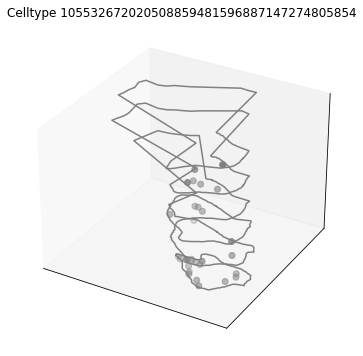

In [38]:
plotting.plot_cell_3D(cells[2])

In [43]:
liver_adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','MERFISH_liver_object.h5ad'))
liver_adata

AnnData object with n_obs × n_vars = 19695 × 307
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'n_counts', 'leiden', 'tentative_annot'
    uns: 'QC_filter', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tentative_annot_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [46]:
liver_adata.obs_names

Index(['112379695218366873860549882516470536890',
       '12559338600922861474440709337722075912',
       '136424294865630680170129609768335163649',
       '156821392620653799987123725353752218857',
       '16787838303036923982065738606329983132',
       '177687241039648906384826541466275797252',
       '179752882524441916760885748558278411476',
       '185193162525487633276499622913202709421',
       '196140021005548455577090968378522944009',
       '197461061844490892926834628814209104026',
       ...
       '336769639109948512799847633774530280492',
       '37369705082198867184324452098992169813',
       '47465432549609365207146527811917312477',
       '5116214556185582295358355847744904350',
       '51816046343979775662564279617477546548',
       '56292141057567723530971261659166166639',
       '68121793071604327723635322621389293215',
       '71391041289612676296610859221534152213',
       '72333849092538517334192547046627660966',
       '89792734333654089648605667575363628015'],


In [64]:
for cell in cells:
    if cell.cell_id not in liver_adata.obs_names:
        continue
    
    cell_row_counts = liver_adata[cell.cell_id]
    ann_num_nonzero_genes = cell_row_counts.to_df().gt(0).sum(axis=1) #number of non-zero genes
    print(cell.cell_id,ann_num_nonzero_genes == len(cell.genes))
    

105072068019172264044024400942929587455 105072068019172264044024400942929587455    True
dtype: bool
106420718922401016279740802697270530490 106420718922401016279740802697270530490    True
dtype: bool
114672465362754693578076179962521408813 114672465362754693578076179962521408813    True
dtype: bool
119324351733658147365996489012828089009 119324351733658147365996489012828089009    True
dtype: bool
124189722950252031134545162381540081661 124189722950252031134545162381540081661    True
dtype: bool
127151027040526450129980854552097627892 127151027040526450129980854552097627892    True
dtype: bool
139282426161430924261881899485944713693 139282426161430924261881899485944713693    True
dtype: bool
16430047309196349380728681407054680553 16430047309196349380728681407054680553    True
dtype: bool
191286158648681877001834682777961615159 191286158648681877001834682777961615159    True
dtype: bool
191780889780920221110799740927987565734 191780889780920221110799740927987565734    True
dtype: bool
20

# Testing another run of the nextflow pipeline

In [66]:
f = h5py.File('/scratch/groups/horence/rob/nextflow_workdirs/SLRRP_preprocessing/work/0e/8e7a7cd2949e4c7da536d8bdac682d/spot_assigned_fov.hdf5','r')
f

<HDF5 file "spot_assigned_fov.hdf5" (mode r)>

In [67]:
f['cell_ids']

<HDF5 dataset "cell_ids": shape (221,), type "|S39">

In [68]:
f['genes']

<HDF5 dataset "genes": shape (232,), type "|S5">

In [69]:
f['cells']

<HDF5 group "/cells" (221 members)>

In [70]:
f.close()

In [71]:
sample = SRRS.HDF5('/scratch/groups/horence/rob/nextflow_workdirs/SLRRP_preprocessing/work/0e/8e7a7cd2949e4c7da536d8bdac682d/spot_assigned_fov.hdf5')
sample

HDF5 /scratch/groups/horence/rob/nextflow_workdirs/SLRRP_preprocessing/work/0e/8e7a7cd2949e4c7da536d8bdac682d/spot_assigned_fov.hdf5

In [76]:
kidney_adata = scp.read_h5ad(os.path.join(stem,'cell_gene_counts','MERFISH_kidney_object.h5ad'))
kidney_adata

AnnData object with n_obs × n_vars = 34404 × 307
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'median average DAPI', 'mean average DAPI', 'dataset', 'barcodeCount', 'n_counts', 'leiden', 'tentative_annot'
    uns: 'QC_filter', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tentative_annot_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [78]:
kidney_adata.obs_names

Index(['41624037509864934454151605501754497245',
       '169867365247332354866338405383324588459',
       '286321852523267750287432641871621919039',
       '102904096940674507421759112800363656347',
       '110601490635990138731130117445235281343',
       '130111078907057673898458323220900242022',
       '141829986921435969513858317181928347056',
       '143565540405990028059553549376138818162',
       '191832012212214254667595309182848622442',
       '206828641344153432208509069691929367647',
       ...
       '22525327933065938095508494974612763642',
       '34465437466992934621007519512373953651',
       '55532683820604546734781766088050308783',
       '247958200157401124897312778666993222858',
       '27439505866825689506051923766571061629',
       '47593230811091457288739115988178061488',
       '80315115277251954840364542894774491563',
       '99057219388376948313953996768424102821',
       '326129378277075365827788779468604261567',
       '98699552266223429585360149923005216399'

In [79]:
cell.cell_id

'99769558201619195399176670171329075266'

In [77]:
for cell in sample.cells():
    if cell.cell_id not in kidney_adata.obs_names:
        continue
    
    cell_row_counts = kidney_adata[cell.cell_id]
    ann_num_nonzero_genes = cell_row_counts.to_df().gt(0).sum(axis=1) #number of non-zero genes
    print(cell.cell_id,ann_num_nonzero_genes == len(cell.genes))
    

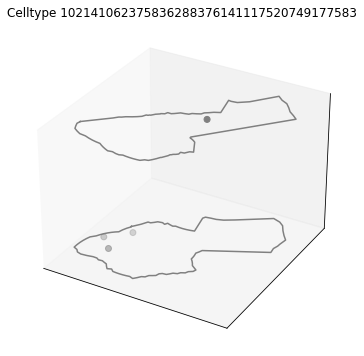

In [75]:
plotting.plot_cell_3D(cell)

# Debugging nextflow preprocess

In [34]:
f = h5py.File('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/KidneyLiver_preprocessing/data/VZG116/MsLiver_Cellbound_VZG116_V1_JH_09-18-2021/features/feature_data_115.hdf5','r')
f

<HDF5 file "feature_data_115.hdf5" (mode r)>

In [35]:
f.keys()

<KeysViewHDF5 ['featuredata']>

In [36]:
f['featuredata']

<HDF5 group "/featuredata" (211 members)>

In [38]:
f.close()

In [2]:
from rtree import index
import collections
import shapely.geometry
import sys

in_f = h5py.File('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/preprocessing/KidneyLiver_preprocessing/data/VZG116/MsLiver_Cellbound_VZG116_V1_JH_09-18-2021/features/feature_data_115.hdf5','r')

#Create the HDF5 file to prepare to write out
out_f = h5py.File('testest.hdf5','w')
out_cells_grp = out_f.create_group('cells')
all_cell_ids = []
all_genes = set()

#Read in the 3D RTree of the spots
p = index.Property()
p.dimension = 3
idx = index.Rtree('/scratch/groups/horence/rob/nextflow_workdirs/SLRRP_preprocessing/work/ee/c0d16ff8bce3e13ad0a87166f19ee3/rtree', properties=p)


In [16]:
for cell_id in in_f['featuredata']:
    in_cell = in_f['featuredata'][cell_id]
    min_x,min_y,max_x,max_y = in_cell.attrs['bounding_box']

    cell_genes = collections.defaultdict(list)
    cell_spots = collections.defaultdict(list)

    polys = {}

    for z,_ in enumerate(in_cell['z_coordinates']):
        print(z)
        #Check if z_slice has any p_0 levels
        z_slice_grp = in_cell['zIndex_{}'.format(z)]
        if 'p_0' not in z_slice_grp:
            sys.stdout.write('cell {} did not have z-slice {}\n'.format(cell_id,z))
            continue

        #Find which spots are in this cell boundary box
        boundary_hits = idx.intersection((min_x, min_y, z, max_x, max_y, z), objects=True)

        #Create a Shapely polygon from the x,y coords at the given z-slice
        xy_s = z_slice_grp['p_0']['coordinates'][0,:,:]
        poly = shapely.geometry.Polygon(xy_s)
        polys[z] = poly

        for hit in boundary_hits:
            gene = hit.object
            x,y = hit.bbox[:2]
            
            point = shapely.geometry.Point(x,y)

            if poly.contains(point):
                cell_genes[z].append(gene.encode()) #TODO need to convert barcode_id to gene name
                cell_spots[z].append([x,y])


        break
    break

0
cell 10145035887587753334848824676025236727 did not have z-slice 0
1


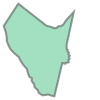

In [17]:
poly

In [18]:
cell_spots

defaultdict(list,
            {1: [[1883.5884, 5559.1025],
              [1883.7167, 5560.130999999999],
              [1884.2994, 5560.2207]]})

In [11]:
print(min_x,min_y,max_x,max_y)

1877.2942830642169 5553.6764906754015 1889.4160529466478 5565.988532325224
